## You will learn: how to look at attention maps.

If you don't know how to load a model yet, look in the notebook __1_Load_model_and_translate__.

### Load trained model

In [1]:
import sys

sys.path.insert(0, 'path_to_the_story_of_heads') # insert your local path to the repo

Load vocabularies.

In [2]:
import pickle
import numpy as np

DATA_PATH = # insert your path
VOC_PATH =  # insert your path

inp_voc = pickle.load(open(VOC_PATH + 'src.voc', 'rb'))
out_voc = pickle.load(open(VOC_PATH + 'dst.voc', 'rb'))

Load model.

In [3]:
%env CUDA_VISIBLE_DEVICES=0

import tensorflow as tf
import lib
import lib.task.seq2seq.models.transformer_head_gates as tr

tf.reset_default_graph()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.99, allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

hp = {
     "num_layers": 6,
     "num_heads": 8,
     "ff_size": 2048,
     "ffn_type": "conv_relu",
     "hid_size": 512,
     "emb_size": 512,
     "res_steps": "nlda", 
    
     "rescale_emb": True,
     "inp_emb_bias": True,
     "normalize_out": True,
     "share_emb": False,
     "replace": 0,
    
     "relu_dropout": 0.1,
     "res_dropout": 0.1,
     "attn_dropout": 0.1,
     "label_smoothing": 0.1,
    
     "translator": "ingraph",
     "beam_size": 4,
     "beam_spread": 3,
     "len_alpha": 0.6,
     "attn_beta": 0,
}

model = tr.Model('mod', inp_voc, out_voc, inference_mode='fast', **hp)

env: CUDA_VISIBLE_DEVICES=0


Load trained model parameters.

In [4]:
path_to_ckpt = # insert path to the final checkpoint
var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
lib.train.saveload.load(path_to_ckpt, var_list)

## Visualize attention maps

### Get attention weights for a head

All attention weights in the model are saved in `tf.collection`. You just need to take them from the `AttnWeights` collection after feeding a batch of sentences. Do not forget to clear collection before that just in case!

In [5]:
def get_all_attns(src_sent):
    feed_dict = model.make_feed_dict([(src_sent, "")])
    tf.get_default_graph().clear_collection("AttnWeights")
    model.transformer.encode(feed_dict['inp'], feed_dict['inp_len'], False)
    info = tf.get_collection("AttnWeights")
    attns = [info[i][0].eval() for i in range(model.transformer.num_layers_enc)]
    return attns

def get_attns(src_sent, layer, head):
    all_attns = get_all_attns(src_sent)
    return all_attns[layer][head]

In [6]:
get_attns(src_sent="i saw a cat", layer=0, head=0)

array([[2.71142460e-02, 7.16518641e-01, 4.18839455e-02, 1.46593405e-02,
        1.99823827e-01],
       [1.04576237e-02, 8.77484307e-02, 8.29643533e-02, 3.46590877e-02,
        7.84170449e-01],
       [2.00368073e-02, 1.30270869e-01, 1.80031043e-02, 1.57493595e-02,
        8.15939903e-01],
       [4.23796329e-04, 2.44938699e-03, 1.80661608e-03, 8.79494660e-03,
        9.86525297e-01],
       [1.17151038e-04, 2.15308362e-04, 2.98917235e-04, 5.37839660e-04,
        9.98830736e-01]], dtype=float32)

### Visualize

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)

def draw_map(sent, attns):
    ticks = sent.split() + ['<eos>']
    plt.imshow(attns, interpolation='none', cmap='Blues')
    plt.xticks(range(len(ticks)), ticks, rotation=90);
    plt.yticks(range(len(ticks)), ticks);
    plt.colorbar(label='attention weights')
    plt.show()

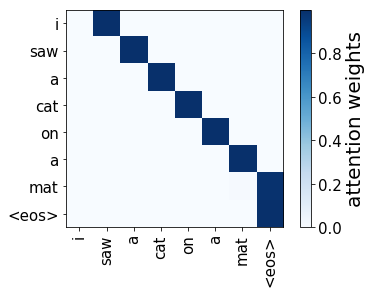

In [8]:
sent = 'i saw a cat on a mat'

draw_map(sent, get_attns(sent, layer=1, head=3))

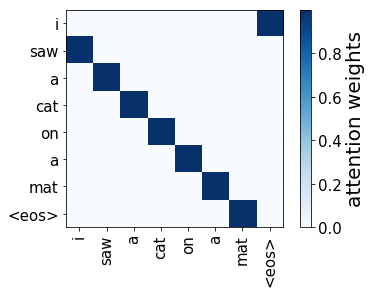

In [9]:
sent = 'i saw a cat on a mat'

draw_map(sent, get_attns(sent, layer=1, head=6))

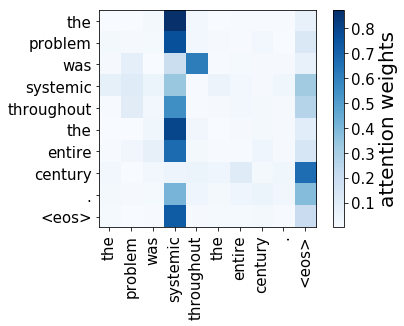

In [10]:
sent = 'the problem was systemic throughout the entire century .'

draw_map(sent, get_attns(sent, layer=0, head=3))